# Creating a SparkContext

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext

In [2]:
conf = SparkConf()

conf.setAppName('miniconda-pyspark')

sc = SparkContext(conf = conf)

# Creating a SQLContext

In [3]:
from pyspark.sql import SQLContext

In [4]:
sqlContext = SQLContext(sc)

# Data cleaning

## Declaring functions

In [5]:
import re

In [6]:
def getName(text):
    return re.search('([^\/])+(?=\_(\d+).+)', text).group()

## Reading JSON

In [7]:
from __future__ import print_function

In [8]:
# [(x, y)]
# x -> path (/directory/filename.extension)
# y -> content ('[values]\n')
# [(path, content)]
rdd = sc.wholeTextFiles('json') 

## Transforming RDD

In [9]:
# removing brackets 
# [(x, y)]
# x -> path (/directory/filename.extension)
# y -> content ('values')
# [(path, content)]
rdd = rdd.map(lambda x: (x[0], x[1][1:-2])) 

In [10]:
# converting string to array of strings
# [(x, [y])]
# x -> path (/directory/filename.extension)
# y -> image_values ([string])
# [(path, image_values)]
rdd = rdd.map(lambda x: (x[0], x[1].split(','))) 

In [11]:
# converting string to float 
# [(x, [y])]
# x -> path (/directory/filename.extension)
# y -> image_values ([float])
# [(path, image_values)]
rdd = rdd.map(lambda x: (x[0], [float(y.strip()) for y in x[1]])) 

In [12]:
# get filename as label
# [(x, [[y]])]
# x -> filename (filename)
# y -> image_values ([[float]])
# [(filename, image_values)]
rdd = rdd.map(lambda x: (getName(x[0]), [x[1]]))

In [13]:
# creating classes
# [(x, [y])]
# x -> filename (filename)
# y -> image_values_set ([[float]])
# [(filename, image_values_set)]
rdd = rdd.reduceByKey(lambda x, y: x + y) 

In [14]:
# adding index
# [((w, x), [y])]
# w -> index
# x -> filename (filename)
# y -> image_values_set ([[float]])
# [((index, filename), image_values_set)]
rdd = rdd.zipWithIndex().map(lambda x: ((x[1], x[0][0]), x[0][1])) 

In [15]:
# splitting data into training and test set
# [((w, x), ([y], [z]))]
# w -> index
# x -> filename (filename)
# y -> train_set ([float])
# z -> test_set ([float])
# [((index, filename), (train_set, test_set))]  
rdd = rdd.map(lambda x: (x[0], (x[1][0:100], x[1][100:])))

# Binary classification

## Training model

In [16]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD

In [17]:
rdd_training = rdd.map(lambda x: (int(bool(x[0][0])), x[1][1])) # selecting training set

In [18]:
rdd_training = rdd_training.flatMap(lambda x: [(x[0], y) for y in x[1]])

In [19]:
rdd_training = rdd_training.map(lambda x: LabeledPoint(int(bool(x[0])), x[1])) # creating training set

In [20]:
#rdd_training.collect()

In [21]:
model = SVMWithSGD.train(rdd_training) # creating model

# Predicting

In [22]:
rdd_testing = rdd.map(lambda x: (x[1][1], (int(bool(x[0][0])), x[0][0], x[0][1]))) # creating testing set

In [23]:
rdd_testing = rdd_testing.flatMap(lambda x: [(y, x[1]) for y in x[0]])

In [24]:
rdd_testing = rdd_testing.map(lambda x: (model.predict(x[0]), x[1])) # predicting on testing set

In [25]:
#rdd_testing.collect()

## Confusion matrix

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [28]:
array = rdd_testing.map(lambda x: (x[0], x[1][0], x[1][2])).collect()

In [29]:
true_label = []
predicted_label = []
text_label = []

columns = {}

for a in array:
    true_label.append(a[1])
    predicted_label.append(a[0])
    text_label.append(a[2])
        
    if not bool(a[1]):
        columns[a[2]] = a[1]

columns['others'] =1       
        
matrix = confusion_matrix(true_label, predicted_label)    

In [30]:
matrix

array([[   0,  100],
       [  80, 3510]])

In [31]:
columns

{'miniature_pinscher': 0, 'others': 1}

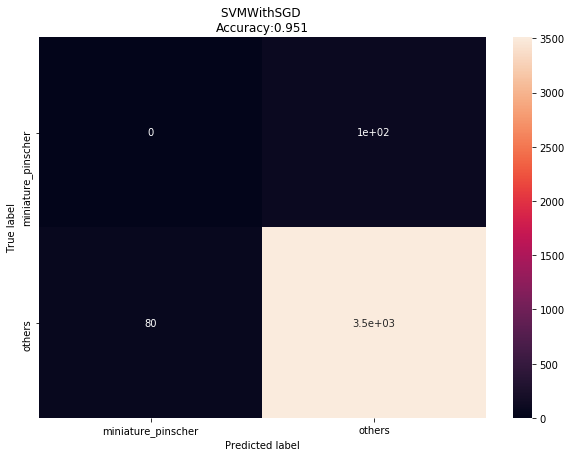

In [32]:
df = pd.DataFrame(matrix, index = columns.keys(), columns = columns.keys())

plt.figure(figsize = (10,7))

sn.heatmap(df, annot = True)

plt.title('SVMWithSGD \nAccuracy:{0:.3f}'.format(accuracy_score(true_label, predicted_label)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()